In [53]:
%matplotlib inline
from numpy import *
from pylab import *

#n=2 # Questo definisce un solo elemento finito 

#x=linspace(0,1,n)

In [54]:
from numpy.polynomial.polynomial import *

#INTRODUCIAMO chebishev per produrre lo spazio duale

def chebyshev_nodes(x):
    cheb = [0.5*cos((2*(i+1)-1)*pi/(2*x)) + 0.5 for i in range(x)]
    cheb = array(cheb)
    return sort(cheb) 
"""
def lagrange_basis(xi, i):
    def func(x):
        assert i<len(xi) and i>=0, 'Out of range: 0 < i < len(xi)'
        ret = 1;
        for xj in xi[range(i)+range(i+1,len(xi))]:
            p = (x-xj)/(xi[i]-xj)
            ret *= p
        return ret
    return func

def lagrange_basis_derivatives(xi, i):
    def func(x):
        deriv_sum=0
        assert i<len(xi) and i>=0, 'Out of range: 0 < i < len(xi)'
        ret = 1;
        for xj in xi[range(i)+range(i+1,len(xi))]:
            p = ((x-xj)/(xi[i]-xj))
            ret *= p
        for xj in xi[range(i)+range(i+1,len(xi))]:
            deriv_sum += 1./(x-xj)
        ret *= deriv_sum    
        return ret
    return func
"""
def lagrange_basis(q,i):
    n = len(q)
    L = Polynomial.fromroots([xj for xj in q if xj != q[i]]) 
    L = L/(L(q[i]))
    return L

def lagrange_basis0(q,i):
    L = product([ (x-q[j])/(q[i]-q[j]) for j in xrange(n+1) if j != i], axis=0)
    return L

def lagrange_basis_derivatives(q,i):
    L_deriv = lagrange_basis(q,i).deriv()
    return L_deriv

def lagrange_function(v,lag_base):
    def func(x):
        res=0
        for i in range(len(v)):
            res += v[i]*lag_base[i](x)
        return res
    return func

degree=2 #grado dei polinomi delle basi 
cheb = chebyshev_nodes(degree+1) #Lista nodi chebichev
#print cheb

lag_bas=[]
lag_bas_deriv=[]

#lagrangian base per i punti chebichev 
for i in range(len(cheb)):
    lag_bas.append(lagrange_basis(cheb,i))
    lag_bas_deriv.append(lagrange_basis_derivatives(cheb,i))
    


In [55]:
N = []
#punti dello spazio duale dove vai a calcolare le funzioni di base 
dual_basis_points = linspace(0,1,degree+1)


for node in dual_basis_points:
    N.append(lambda f, node=node : f(node))



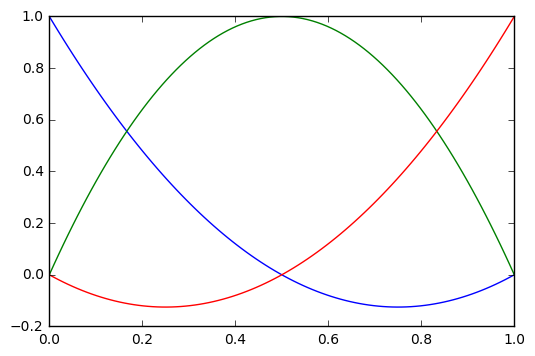

In [56]:
# Dimension of the polynomial space
n = len(N) 

C = zeros((n,n)) # Matrix for the change of variables
for i in range(n):
    for j in range(n):
        C[i,j] = N[i](lag_bas[j])
        

# Auxiliary space to plot the result
s = linspace(0,1,100)
V = []
V_prime=[]
for k in range(n):
    ei = zeros((n,))
    ei[k] = 1. # delta_ik
    vk = linalg.solve(C, ei)
    V.append(lagrange_function(vk,lag_bas)) # Construct the basis using the right coefficients of the polynomials
    V_prime.append(lagrange_function(vk,lag_bas_deriv))
    plot(s, V[k](s))
    
#print len(V), array(V).shape, V[0]
  
#Qui abbiamo costruito i vk che sono i coefficienti 

In [57]:
V_prime[1](0.5)

0.0

Now we have our local basis functions, constructed using **exclusively** the definition of the **Finite Element**, i.e., a reference element ([0,1]), a polynomial space, and a basis for the dual of the polynomial space.

In [58]:
from numpy.polynomial.legendre import leggauss

deg = 2*len(N)-1
q,w = leggauss(deg) # Gauss between -1 and 1
q = (q+1)/2 # Go back to 0,1 
w = w/2
#uso gauss perche cosi ottengo la soluzione esatta fino a un certo grado 
#mi tira fuori i punti di quadratura e il peso di ciascun punto 

print q
print deg

[ 0.04691008  0.23076534  0.5         0.76923466  0.95308992]
5


Now we evaluate all local basis functions and all derivatives of the basis functions at the quadrature points.

In [59]:
Vq = zeros((len(N), len(q)))
Vpq = zeros((len(N), len(q)))


        
#Le righe di Vq sono le funzioni di base calcolate sui punti di quadratura 
for i in range(len(N)):
    Vq[i] = V[i](q)
    #print "----", Vq[i]
    Vpq[i] = V_prime[i](q)
    #Vpq[i] = nan_to_num(V_prime[i](q))
    
VqVq = einsum('ij,kl -> ikjl', Vq,Vq) #passaggio a 2D delle funzioni di base 
print VqVq.shape
VqVpq = einsum('ij,kl -> ikjl', Vq,Vpq) #passaggio a 2D delle funzioni di base 
#print "------ ", VqVpq 
VpqVq = einsum('ij,kl -> ikjl', Vpq,Vq) #passaggio a 2D delle funzioni di base 

#i funzione di base lungo x, k funzione di base lungo y  
#j punto dove viene valutata la funzione lungo x, l punto dove vine valuta la funzione lungo y 
VpqVpq=einsum('ij,kl -> ikjl', Vpq,Vpq)
#L[1,2,3,4] => L1(q3)L2(q4)

from mpl_toolkits.mplot3d import Axes3D #serve solo per plottare 


Q = meshgrid(q[:], q[:]) # per la griglia 

(3, 3, 5, 5)


In [60]:

#myf = lambda x: (4*pi**2*sin(2*pi*x))
#myf = lambda x: x
#myf = lambda x,y: (((2*pi)**2) + 1)*cos(pi*x)*sin(pi*y) 
myf_test = lambda x,y: (2*(pi**2) + 1)*cos(pi*y)*cos(pi*x)
#print "L.shape", L.shape, L.shape[:dim], L.shape[dim:]
#print "____", prod(L.shape[:dim]), prod(L.shape[dim:])
dim=2

VqVq = reshape(VqVq, (prod(VqVq.shape[:dim]), prod(VqVq.shape[dim:])))
print "------", VqVq.shape
VqVpq = reshape(VqVpq, (prod(VqVpq.shape[:dim]), prod(VqVpq.shape[dim:])))
#print "------", VqVpq
#VqVpq = nan_to_num(VqVpq)
#print "------", VqVpq
VpqVq = reshape(VpqVq, (prod(VpqVq.shape[:dim]), prod(VpqVq.shape[dim:])))
#VpqVq = nan_to_num(VpqVq)
#print "------", VpqVq
VpqVpq = reshape(VpqVpq, (prod(VpqVpq.shape[:dim]), prod(VpqVpq.shape[dim:])))
#VpqVpq = nan_to_num(VpqVpq)
#print "------", VpqVpq 

#print "------- Lp", Lf_prime.shape
W=einsum('i,j->ij',w,w)

Wf=reshape(W, (prod(W.shape[:dim]))) #ordino come prima 
#print "------- Wf",  Wf.shape
#print q
#Q_rh=einsum('i,j->ij',q,q)
#Qf=reshape(Q_rh, (prod(Q_rh.shape[:dim]))) # serve per rhs 
#print Q_rh
#print Q_rh.shape
#print "--------- Qf", Qf


latticeq_points = np.array([[[qx,qy] for qy in q] for qx in q ])
latticeq_points = latticeq_points.reshape(len(q)*len(q),2)

lpoint_x = np.array([latticeq_points[i,0] for i in range(len(latticeq_points))])
lpoint_y = np.array([latticeq_points[i,1] for i in range(len(latticeq_points))])



#A = einsum('jq, iq, q -> ij', Lf_prime/h, Lf_prime/h, Wf)
A = einsum('jq, iq, q -> ij', VqVpq, VqVpq, Wf)
A += einsum('jq, iq, q -> ij', VpqVq, VpqVq, Wf)

#print "--------  A", A

M = einsum('jq, iq, q -> ij', VqVq, VqVq, Wf)
#print "--------  A", M
rhs = einsum('iq, q, q -> i', VqVq,Wf,myf_test(lpoint_x,lpoint_y)) #inserita

#print len(rhs)



# Solve the system
ufem = linalg.solve((A + M), rhs)
print ufem, len(ufem)

# [ 0.9994358   0.49343163 -0.49343163 -0.9994358   0.49343163  0.24361578
# -0.24361578 -0.49343163 -0.49343163 -0.24361578  0.24361578  0.49343163
# -0.9994358  -0.49343163  0.49343163  0.9994358 ]


------ (9, 25)
[  1.22635075e+00   7.89151710e-16  -1.22635075e+00   7.03227898e-16
   4.86969401e-16   3.02274290e-16  -1.22635075e+00   3.33047481e-16
   1.22635075e+00] 9


(5, 5, 3, 3)
(9,)
(3, 3)


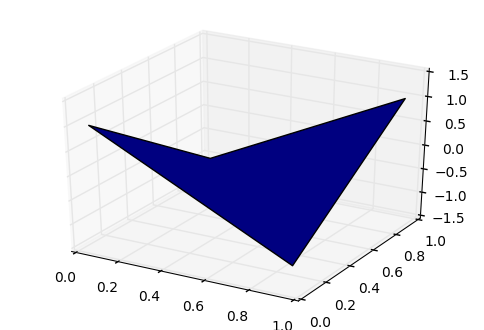

In [65]:
Vcheb = zeros((n, len(q)))

for j in range(degree + 1):
    Vcheb[j] = V[j](q)

C = einsum('is, jk -> skij', Vcheb, Vcheb)
print C.shape
print ufem.shape
print ufem.reshape(n,n).shape

sol = einsum('skij, ij', C, ufem.reshape(n, n))

u_fem= sol.reshape(len(q)**dim,)

cheb = chebyshev_nodes(degree+1)
    
X, Y = meshgrid(q,q)
u_fem = u_fem.reshape((len(q),len(q)))
    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X,Y,u_fem)
plt.show()

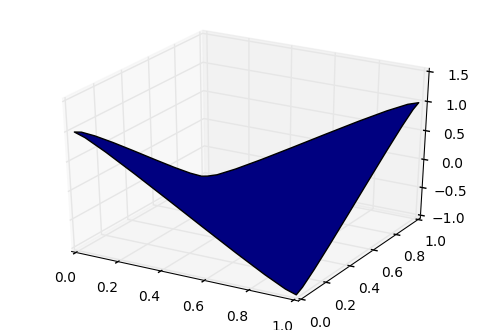

In [21]:
from mpl_toolkits.mplot3d import Axes3D



# Plots
ns = 51
s = linspace(0,1,ns)

Ls = zeros((n, ns))
for j in range(n):
    Ls[j] = V[j](s)


X, Y = meshgrid(cheb,cheb)

sol_fe = ufem.reshape((degree+1,degree+1))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,sol_fe)


In [ ]:
sol_ext = lambda x,y: cos(pi*x)*cos(pi*y)

#s = linspace(0,1,30)
X, Y = meshgrid(cheb,cheb)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X,Y,sol_ext(X,Y))

In [134]:
sol_ext_p = []

for i in cheb:
    for j in cheb:
        sol_ext_p.append(sol_ext(i,j))

sol_ext_p = array(sol_ext_p)
print sol_ext_p

print max(abs(sol_ext_p - sol_fe.reshape(len(sol_ext_p),)))

[  9.56362099e-01   5.98814123e-17  -9.56362099e-01   5.98814123e-17
   3.74939946e-33  -5.98814123e-17  -9.56362099e-01  -5.98814123e-17
   9.56362099e-01]
0.26998865566


In [135]:
# mod